## ОПИСАНИЕ ЭКСПЕРИМЕНТА
Перед вами таблица, где числовая переменная – непрерывная. Задача – сравнить группы двумя способами: бутстрапом и u-тестом

## ОПИСАНИЕ КОЛОНОК
value – значения метрики\
experimentVariant – Вариант теста (Control – контроль, Treatment – тест)

## ЗАДАЧА
### 1. Сравните результат между тестом и контролем по двум кейсам:
Примените бутстрап (с np.mean) и критерий mann-whitney, а потом сравните p-value
Примените бутстрап (с np.median) и критерий mann-whitney, а потом сравните p-value.

### 2. Напишите выводы, которые можно сделать на основе анализа примененных критериев

---

In [24]:
import numpy as np
import pandas as pd
from scipy.stats import norm, mannwhitneyu, shapiro
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

plt.rcParams["figure.figsize"] = (10,7)

In [25]:
df = pd.read_csv('https://stepik.org/media/attachments/lesson/396008/hw_bootstrap.csv', sep=';', index_col=0)

In [26]:
df

,value,experimentVariant
1,"10,3804953740268",Control
2,"9,54686666784264",Control
3,"11,0882146509904",Control
4,"10,1472740570122",Control
5,"9,78980767524929",Control
...,...,...
996,1000,Treatment
997,1200,Treatment
998,1500,Treatment
999,2000,Treatment


---

<font size=6>1.Проверка и предподготовка данных</font>

In [27]:
#Проверяем наличие пропущенных значений
df.isnull().sum()

value                0
experimentVariant    0
dtype: int64

In [28]:
#Проверяем типы данных
df.dtypes

value                object
experimentVariant    object
dtype: object

In [29]:
#Изменяем тип данных в колонке value, перед этим заменив запятые на точки
df['value'] = df.value.str.replace(',', '.')
df['value'] = df['value'].astype('float32')

In [30]:
df.dtypes

value                float32
experimentVariant     object
dtype: object

In [31]:
#Проверяем наличие отрицательных значений
df.query('value < 0').count()

value                0
experimentVariant    0
dtype: int64

---

<font size=6>2.Формирование выборок</font>

In [32]:
# Формируем выборки Control и Treatment
ctrl = df.query('experimentVariant == "Control"').value
trnt = df.query('experimentVariant == "Treatment"').value

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Рис. 1 Распределение значений в выборке Control')

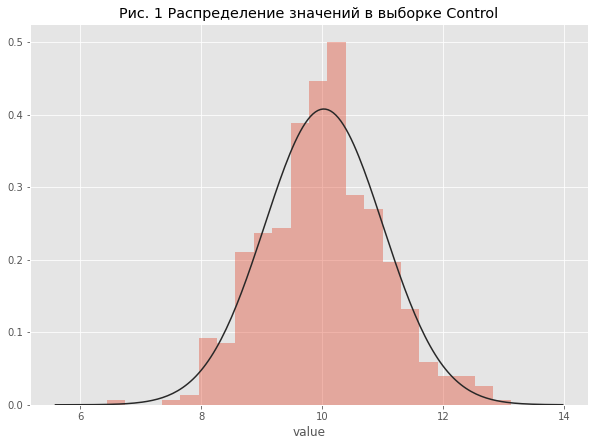

In [33]:
sns.distplot(ctrl,kde=False,fit=norm).set_title("Рис. 1 Распределение значений в выборке Control")

### Распределение, на первый взгляд, похоже на нормальное, проведем тест Шапиро-Уилка.

In [34]:
stat_shapiro, p_shapiro = shapiro(ctrl)
print('Statistics=%.3f, p=%.3f' % (stat_shapiro, p_shapiro))

Statistics=0.996, p=0.224


### P-значение больше уровня значимости, отвергнуть нулевую гипотезу не можем. Так как нулевая гипотеза в случае Шапиро-Уилка - нормальность распределения, то здесь мы можем сделать вывод, что распределение в выборке Control является нормальным.

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Рис. 2 Распределение значений в выборке Treatment')

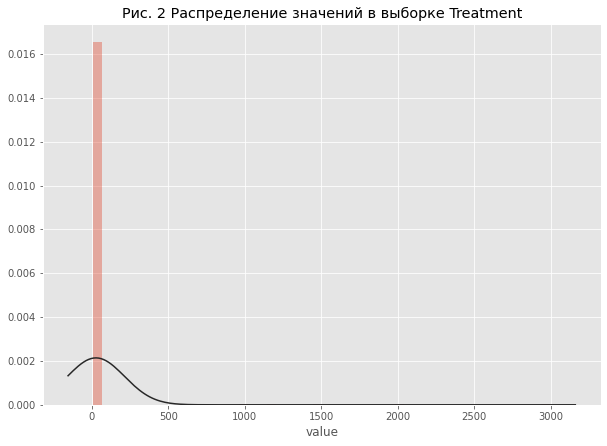

In [35]:
sns.distplot(trnt,kde=False,fit=norm).set_title("Рис. 2 Распределение значений в выборке Treatment")

### Распределение значений в выборке Treatment не является нормальным, можно проверить является ли оно log-нормальным.


/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Рис. 3 Распределение прологарифмированных значений в выборке Treatment')

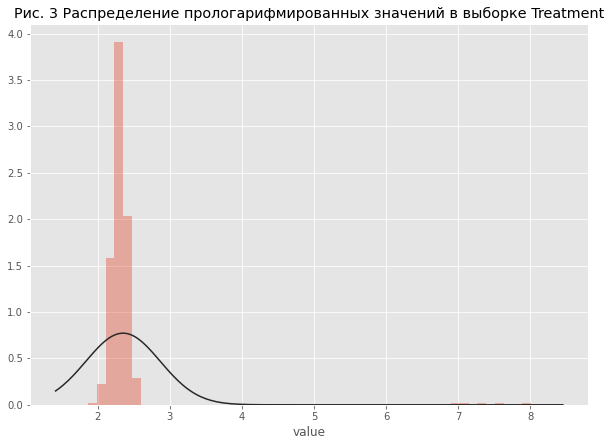

In [36]:
sns.distplot(np.log(trnt),kde=False,fit=norm).set_title("Рис. 3 Распределение прологарифмированных значений в выборке Treatment")

### На графике (Рис. 3) можно увидеть, что распределение значений в выборке Treatment возможно является log-нормальным без учета дальних выбросов в правой части. Возможно, с точки зрения дизайна исследования, выбросы, находящиеся далеко справа, можно удалить, но это неизвестно. Можно, по крайней мере, проверить, как будет выглядеть без них.

In [37]:
trnt.sort_values(ascending=False).head(10)

1000    3000.000000
999     2000.000000
998     1500.000000
997     1200.000000
996     1000.000000
672       13.130345
696       12.817540
795       12.728285
864       12.663784
720       12.598569
Name: value, dtype: float32

### Есть сомнения, что 5 максимальных значений в выборке Treatment не являются ошибками при проведении эксперимента или случайно подставленными тренировочными выбросами.

In [38]:
trnt_no_outliers = trnt.where(trnt < 20).dropna()

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


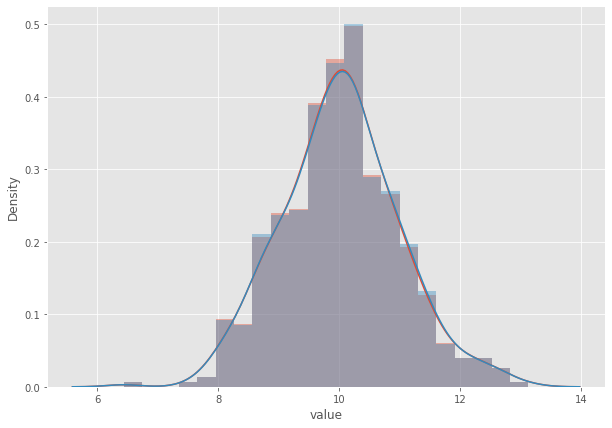

In [39]:
sns.distplot(trnt_no_outliers)
sns.distplot(ctrl)

### Наверное, на этом можно было бы завершить, однако, проведем необходимые тесты.

---

<font size=6>3.Тест Манна-Уитни</font>

In [44]:
#Выполняем U-тест
stat, p = mannwhitneyu(ctrl, trnt, alternative='two-sided')
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=124189.500, p=0.859


### Тест Манна-Уитни показал, что значимые различия в выборках подтвердить мы не можем. Известно, что этот тест хорошо справляется с выбросами.

---

<font size=6>4.Bootstrap+Mean</font>

In [41]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

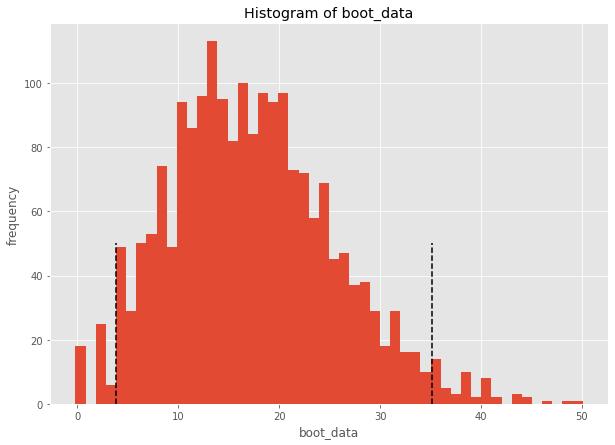

Bootstrap+Mean P-value = 0.034


In [42]:
booted_data_mean = get_bootstrap(trnt, ctrl, boot_it = 2000)
print('Bootstrap+Mean P-value = %.3f' % (booted_data_mean["p_value"]))

### Несмотря на то, что p-value технически позволяет нам отвергнуть нулевую гипотезу, не нужно пока делать выводы.

---

<font size=6>5.Bootstrap+Median</font>

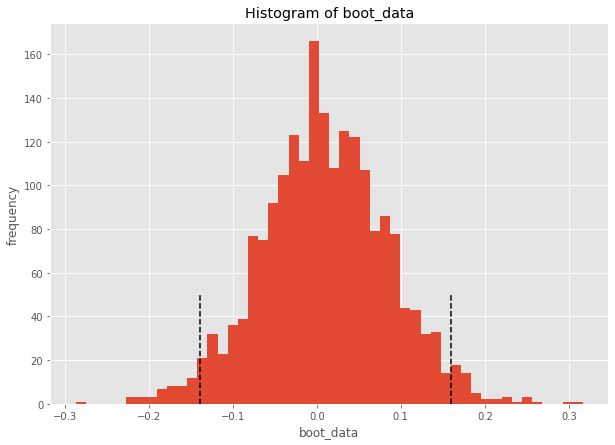

Bootstrap+Median P-value = 0.894


In [43]:
booted_data_median = get_bootstrap(trnt, ctrl, statistic=np.median, boot_it = 2000) 
print('Bootstrap+Median P-value = %.3f' % (booted_data_median["p_value"]))

### P-value при применении Bootstrap+Median говорит о том, что нулевую гипотезу о равенстве медиан в двух выборках нельзя отклонять.

___

<font size=6><span style="color:black">6.Выводы</span></font>

- Cхема кейса Bootstrap+Mean очень чувствительна к выбросам, настолько, что из-за нескольких серьезных отклонений от основного массива значений технически дает право отвергнуть нулевую гипотезу о равенстве средних в выборках Control и Treatment;

- Если убрать выбросы из выборки Treatment и наложить с выборкой Control на один график, то это - практически идентичные распределения. В данном случае похоже на тренировочный случай, однако, в реальных задачах нельзя убирать выбросы до обсуждения с теми, кто занимался дизайном эксперимента и сбором данных;

- Тест Манна-Уитни позволяет дополнительно убедиться в том, что кейс Bootstrap+Median хорошо отработал, в ситуации с наличием серьезных выбросов;

- Если делать "продуктовый" вывод, то нельзя считать результаты в выборке Treatment значимо отличающимися от выборки Control. Также можно посоветовать подумать о редизайне эксперимента с целью выяснения происхождения выбросов.